## Imports

In [47]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
from warnings import simplefilter
import requests
import sys
from sklearn.feature_extraction.text import TfidfVectorizer


##### Helper functions:

In [48]:
# Replace with your actual TMDB API key
global API_KEY

API_KEY = ""
def fetch_movie_id(title, api_key):
    """
    Searches for a movie by title and returns the first movie ID if found.
    Returns None if no match is found.
    """
    search_url = "https://api.themoviedb.org/3/search/movie"
    params = {
        "api_key": api_key,
        "query": title
    }
    
    response = requests.get(search_url, params=params)
    data = response.json()
    
    results = data.get("results", [])
    if results:
        return results[0].get("id")
    return None

def fetch_keywords_for_movie(movie_id, api_key):
    """
    Given a TMDB movie ID, returns a list of keyword strings.
    """
    keywords_url = f"https://api.themoviedb.org/3/movie/{movie_id}/keywords"
    params = {"api_key": api_key}
    
    response = requests.get(keywords_url, params=params)
    data = response.json()
    
    keywords_data = data.get("keywords", [])
    return [kw.get("name") for kw in keywords_data]

def main(df):
    total_rows = len(df)
    processed_count = 0
    
    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        # If 'keywords' is empty or NaN, attempt to fetch from TMDB
        if pd.isnull(row['keywords']) or str(row['keywords']).strip() == "":
            title = row['title']
            
            # Fetch TMDB movie ID by title
            movie_id = fetch_movie_id(title, API_KEY)
            
            if movie_id:
                # Get the keywords for this movie
                keywords_list = fetch_keywords_for_movie(movie_id, API_KEY)
                updated_keywords = ", ".join(keywords_list)
                df.at[index, 'keywords'] = updated_keywords
        
        processed_count += 1
        
        # Update counter in place (no newline)
        print(f"\rProcessed {processed_count} of {total_rows} rows.", end="", flush=True)
        
    return df

def extract_keywords_tfidf(texts, num_keywords=10):
    """
    Extract keywords from movie overviews using TF-IDF.
    
    Parameters:
        texts (list): List of movie overview texts.
        num_keywords (int): Number of keywords to extract per movie.
    
    Returns:
        list: List of extracted keywords for each movie.
    """
    # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
    
    # Transform texts into TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Get feature names (words)
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    # Extract top keywords for each movie
    keywords_list = []
    for row in tfidf_matrix:
        indices = np.argsort(row.toarray()).flatten()[-num_keywords:]
        keywords = feature_names[indices]
        keywords_list.append(', '.join(keywords))
    
    return keywords_list

def fill_empty_value(merged_df):
    df = main(merged_df)

    # Fill missing overviews with empty strings
    df['overview'] = df['overview'].fillna('')

    # Identify rows with missing keywords
    missing_keywords_mask = df['keywords'].isna()

    # Apply TF-IDF keyword extraction to missing rows
    df.loc[missing_keywords_mask, 'keywords'] = extract_keywords_tfidf(df.loc[missing_keywords_mask, 'overview'])

    # Save the updated dataset
    df.to_csv("movies_tuned.csv", index=False)

    print("Missing keywords have been successfully generated and saved.")

    return df

## Data Exploration

### 1. Read the data

In [49]:
simplefilter("ignore")

movies_df = pd.read_csv('movies_metadata.csv')
rating_df = pd.read_csv('ratings.csv')
keywords_df = pd.read_csv('keywords.csv')
credits_df = pd.read_csv('credits.csv')

pd.set_option('display.max_columns', None)

### 1.1 Explore movies_df data

In [50]:
print(movies_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [51]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [52]:
print(movies_df.isna().sum())

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64


In [53]:
print(movies_df.duplicated().sum())

13


From a brief exploration of this huge dataset, we are able to identify some issues within this dataset:
1. There contains multiple columns (genres, production_companies etc.) where the data is formatted in a Json list structure.
2. There are multiple na. values within the dataset.
3. There are data that does not make much sense (e.g. $0 for revenue & budget)
4. There are some uneeded columns (Title and Original Title)
5. The data type of some features need to be changed accordingly (e.g budget & release date)
6. There exist duplicated rows for our data



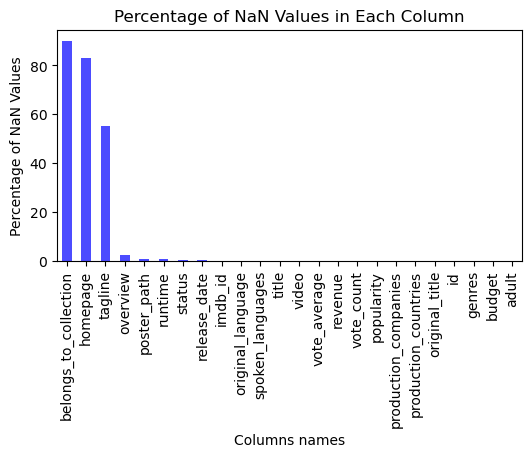

In [54]:
# Show percentage of data is na. values for all column in a bar chart
na_percentage = movies_df.isna().sum() / len(movies_df) * 100

# Plot bar chart
plt.figure(figsize=(6, 3))
na_percentage.sort_values(ascending=False).plot(kind='bar', color='blue', alpha=0.7)
plt.title('Percentage of NaN Values in Each Column')
plt.xlabel('Columns names')
plt.ylabel('Percentage of NaN Values')
plt.xticks(rotation=90)
plt.show()

In [55]:
# Remove duplicate data
movies_df.drop_duplicates(inplace=True)

### 1.2 Explore rating_df data

In [56]:
print(rating_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB
None


In [57]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [58]:
rating_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Within rating_df, there are no missing values, it consist of multiple userId, linked with the movieId to give a rating of the movie. timestamp refers to the time the review is posted(**to be verified**). We can group this dataframe according to the userID later. First we convert the timestamp into a date time format.

In [59]:
# convert timestamp into date time
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'], unit='s')

In [60]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,2015-03-09 22:52:09
1,1,147,4.5,2015-03-09 23:07:15
2,1,858,5.0,2015-03-09 22:52:03
3,1,1221,5.0,2015-03-09 22:52:26
4,1,1246,5.0,2015-03-09 22:52:36


### 1.3 Explore keywords_df data

In [61]:
print(keywords_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB
None


In [62]:
keywords_df.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [63]:
keywords_df.isna().sum()

id          0
keywords    0
dtype: int64

In [64]:
empty_count = (keywords_df['keywords'] == '[]').sum()

print(f"Number of empty lists: {empty_count}")

Number of empty lists: 14795


WHile keyword_df does not have any null values, upon closer look we noticed that a lot of values were empty lists '[]'.

The count is 14795. We want to fix this.

Within keyboard_df, there are no duplicated values. The extracted keywords are mapped to the movie id and stored in a JSON list format. We will convert them them into comma seperated strings similar to movies_df.

### 1.4 Explore credits_df data

In [65]:
print(credits_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB
None


In [66]:
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [67]:
print(credits_df.isna().sum())

cast    0
crew    0
id      0
dtype: int64


credits_df does not contain any missing value, the data contains 2 JSON list files fo cast and crew. There are multiple name for each cast, map to the actors. There are multiple roles and positions with names mapped to it. All these data are linked to the movie id from movie_df. It is not feasable to store all of the cast and crew that works on a movie. So we will extract the first few cast actor and the most prominent position for crew.

## Data Cleaning

In [68]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45453 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45453 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45453 non-null  object 
 3   genres                 45453 non-null  object 
 4   homepage               7780 non-null   object 
 5   id                     45453 non-null  object 
 6   imdb_id                45436 non-null  object 
 7   original_language      45442 non-null  object 
 8   original_title         45453 non-null  object 
 9   overview               44499 non-null  object 
 10  popularity             45448 non-null  object 
 11  poster_path            45067 non-null  object 
 12  production_companies   45450 non-null  object 
 13  production_countries   45450 non-null  object 
 14  release_date           45366 non-null  object 
 15  revenue

### 2.1 Convert column datatype



##### Handle Missing Data:
- Numeric columns are in the correct type for calculations.
- Missing or invalid values are handled appropriately (e.g., dropped or filled).
- Date columns are in a usable datetime format.
- Boolean-like data is standardized as integers.

##### Changes Made:
- **`movies_df['id']`**:
  - Converted to numeric using `pd.to_numeric(..., errors='coerce')`.
  - Dropped rows with `NaN` values in `id` using `dropna(subset=['id'])`.
  - Converted to integer type with `astype(int)`.

- **`movies_df['vote_average']`**:
  - Converted to numeric with `pd.to_numeric(..., errors='coerce')`.
  - Filled `NaN` values with `0` using `fillna(0)`.

- **`movies_df['popularity']`**:
  - Converted to numeric with `pd.to_numeric(..., errors='coerce')`.
  - Filled `NaN` values with `0` using `fillna(0)`.

- **`movies_df['budget']`**:
  - (Commented out) Intended to convert to numeric and fill `NaN` with `0`.

- **`movies_df['adult']`**:
  - Converted boolean-like string values (`'True'`/`'False'`) to integers (`1`/`0`) using a lambda function.

- **`movies_df['release_date']`**:
  - Converted to datetime format with `pd.to_datetime(..., errors='coerce')`.

- **`rating_df['movieId']`**:
  - Converted to numeric with `pd.to_numeric(..., errors='coerce')`.

In [69]:
# Change Data Types
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce')
movies_df = movies_df.dropna(subset=['id'])
movies_df['id'] = movies_df['id'].astype(int)
movies_df['vote_average'] = pd.to_numeric(movies_df['vote_average'], errors='coerce').fillna(0)
movies_df['popularity'] = pd.to_numeric(movies_df['popularity'], errors='coerce').fillna(0)
# movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce').fillna(0)
movies_df['adult'] = movies_df['adult'].apply(lambda x: 1 if x == 'True' else 0)
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')
rating_df['movieId'] = pd.to_numeric(rating_df['movieId'], errors='coerce')

### 2.2 Cleaning movies_df data

#### 2.2.1 id column

In [70]:
duplicated_movies = movies_df['id'].duplicated()
# Drop duplicate movies
movies_df[duplicated_movies].drop_duplicates(inplace=True)

We drop movies that are duplicated in the dataset

#### 2.2.2 Json list format to string

In [71]:
# Convert string object to dictionary
movies_df['belongs_to_collection'] = movies_df['belongs_to_collection'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract name from dictionary
movies_df["belongs_to_collection"] = movies_df["belongs_to_collection"].apply(
    lambda x: x['name'] if isinstance(x, dict) else np.nan
)

# Parse genres from JSON string format if necessary
import json

def extract_genres(genres_str):
    try:
        if isinstance(genres_str, str):
            # Try to parse as JSON first
            try:
                genres_list = json.loads(genres_str.replace("'", '"'))
            except:
                # If that fails, try ast.literal_eval
                try:
                    genres_list = ast.literal_eval(genres_str)
                except:
                    return []

            # Extract genre names
            return [g['name'] for g in genres_list if 'name' in g]
    except:
        pass
    return []

movies_df['genres_list'] = movies_df['genres'].apply(extract_genres)
movies_df['genres_str'] = movies_df['genres_list'].apply(lambda x: ', '.join(x))

# Extract production companies from dictionary
movies_df["production_companies"] = movies_df["production_companies"].apply(
    lambda x: ', '.join([company['name'] for company in ast.literal_eval(x)]) if isinstance(x, str) and x.startswith("[") else np.nan
)

# Extract production countries from dictionary
movies_df["production_countries"] = movies_df["production_countries"].apply(
    lambda x: ', '.join([country['name'] for country in ast.literal_eval(x)]) if isinstance(x, str) and x.startswith("[") else np.nan
)

# Extract spoken languages from dictionary
movies_df["spoken_languages"] = movies_df["spoken_languages"].apply(
    lambda x: ', '.join([language['name'] for language in ast.literal_eval(x)]) if isinstance(x, str) and x.startswith("[") else np.nan
)

The Json list is converted into comma-separated strings

#### 2.2.3 Dealing with na. values

In [72]:
print(movies_df.isna().sum())

adult                        0
belongs_to_collection    40959
budget                       0
genres                       0
homepage                 37673
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   0
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      3
runtime                    260
spoken_languages             3
status                      84
tagline                  25042
title                        3
video                        3
vote_average                 0
vote_count                   3
genres_list                  0
genres_str                   0
dtype: int64


We do not need to know the specific details of these columns. We only want to know if they have these features for their movies. So we will change the name of the column and set it to 1 / 0 for the values.

In [73]:
# Replace the column with true false
movies_df['has_collection'] = movies_df['belongs_to_collection'].notna().astype(int)
movies_df['has_overview'] = movies_df['overview'].notna().astype(int)
movies_df['has_homepage'] = movies_df['homepage'].notna().astype(int)
movies_df['has_tagline'] = movies_df['tagline'].notna().astype(int)
movies_df['has_poster'] = movies_df['poster_path'].notna().astype(int)

- Created new columns to indicate whether certain columns have non-null values:
  - **`has_collection`**: 1 if `belongs_to_collection` is not null, 0 otherwise.
  - **`has_overview`**: 1 if `overview` is not null, 0 otherwise.
  - **`has_homepage`**: 1 if `homepage` is not null, 0 otherwise.
  - **`has_tagline`**: 1 if `tagline` is not null, 0 otherwise.
  - **`has_poster`**: 1 if `poster_path` is not null, 0 otherwise.
- Used `notna()` to check for non-null values and `astype(int)` to convert `True`/`False` to `1`/`0`.

Since we created a new columns for these features, we can drop the old columns

In [74]:
movies_df = movies_df.drop(columns=['homepage', 'tagline', 'poster_path'])

There are some columns where the data cannot be replaced with another value such as runtime & imdb_id. We also want movies that are released. Since we only have released movies, we can drop the status column.

In [75]:
# Only released movies
movies_df = movies_df[movies_df["status"] == "Released"]

# Drop status column
movies_df = movies_df.drop(columns=["status"])

Remove all unreleased movies

In [76]:
# Remove rows
movies_df = movies_df.dropna(subset=['runtime', 'imdb_id', 'release_date', 'revenue', 'spoken_languages', 'original_language'])

In [77]:
print(movies_df.isna().sum())

adult                        0
belongs_to_collection    40207
budget                       0
genres                       0
id                           0
imdb_id                      0
original_language            0
original_title               0
overview                   666
popularity                   0
production_companies         0
production_countries         0
release_date                 0
revenue                      0
runtime                      0
spoken_languages             0
title                        0
video                        0
vote_average                 0
vote_count                   0
genres_list                  0
genres_str                   0
has_collection               0
has_overview                 0
has_homepage                 0
has_tagline                  0
has_poster                   0
dtype: int64


In [78]:
# Fill null values in overview and belong to collection
movies_df.loc[movies_df['belongs_to_collection'].isnull(),'belongs_to_collection'] = 'no collection'
movies_df.loc[movies_df['overview'].isnull(),'overview'] = 'no overview'

Now there are no more missing values in the data. But there are more data cleaning to be done.

#### 2.2.4 Removing data that does not make sense

In [79]:
print(len(movies_df))

44664


In [80]:
# Count unique values in video column
print(movies_df['video'].value_counts())

video
False    44576
True        88
Name: count, dtype: int64


The ratio of False to True row is too high to be of use, we can safely drop this column.

In [81]:
movies_df.drop(columns=['video'], inplace=True)

Certain movies does not have a budget which does not make sense. So we remove all movies that have a budget of 0

In [82]:
movies_df = movies_df[movies_df['budget'] != 0]
print(len(movies_df))

44664


In [83]:
print(len(movies_df))
# Show number of runtime = 0
print(movies_df[movies_df['runtime'] == 0]['runtime'].value_counts())

44664
runtime
0.0    1474
Name: count, dtype: int64


There seems to be movies with run time of 0 mins. This should not be the case. So we can drop those rows. Let's take a look at some movies that are less than 60 mins and more than 200 mins.

In [84]:
movies_df = movies_df[movies_df['runtime'] != 0]
print(len(movies_df))

43190


Lets check if there are movies with 0 votes

In [85]:
# Show number of vote count = 0
print(movies_df[movies_df['vote_count'] == 0]['vote_count'].value_counts())

vote_count
0.0    2382
Name: count, dtype: int64


In [86]:
# Show number of vote count = 0
print(movies_df[movies_df['vote_average'] == 0]['vote_average'].value_counts())

vote_average
0.0    2466
Name: count, dtype: int64


It seems we have movies without votes and vote average of 0, let's remove them.

In [87]:
movies_df = movies_df[movies_df['vote_count'] != 0]
print(len(movies_df))

40808


In [88]:
movies_df = movies_df[movies_df['vote_average'] != 0]
print(len(movies_df))

40724


There are movies without revenue, let see how many there are in the dataset

In [89]:
# Show number of revenue = 0
print(movies_df[movies_df['revenue'] == 0]['revenue'].value_counts())

revenue
0.0    33389
Name: count, dtype: int64


Since this is a huge amount of data that will be dropped from our dataset, we can try keeping movies with 0 revenue but with high popularity / votes. Let's set movies where vote count is more than 100 and the popularity is more than 10

In [90]:
movies_df = movies_df[(movies_df["budget"] != 0) | (movies_df["vote_count"] > 100) | (movies_df["popularity"] > 10)]
print(len(movies_df))

40724


#### 2.2.5 Dropping Uneeded Columns

In [91]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40724 entries, 0 to 45463
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  40724 non-null  int64         
 1   belongs_to_collection  40724 non-null  object        
 2   budget                 40724 non-null  object        
 3   genres                 40724 non-null  object        
 4   id                     40724 non-null  int32         
 5   imdb_id                40724 non-null  object        
 6   original_language      40724 non-null  object        
 7   original_title         40724 non-null  object        
 8   overview               40724 non-null  object        
 9   popularity             40724 non-null  float64       
 10  production_companies   40724 non-null  object        
 11  production_countries   40724 non-null  object        
 12  release_date           40724 non-null  datetime64[ns]
 13  revenu

### 2.3 Cleaning keywords_df data

In [92]:
print("Loading and processing keywords data...")


# Load keywords data
print(f"Keywords data loaded: {len(keywords_df)} entries")

# Function to parse keywords but leave empty values unchanged
def parse_keywords(keywords_str):
    if pd.isna(keywords_str) or keywords_str == '':
        return keywords_str  # Leave NaN or empty values unchanged
    try:
        # Extract keyword names from the JSON-like string
        keywords_list = ast.literal_eval(keywords_str)
        return ' '.join([keyword['name'].replace(" ", "").lower() for keyword in keywords_list])
    except:
        return keywords_str  # If parsing fails, leave the original value unchanged

# Apply function to keywords column
keywords_df['keywords_str'] = keywords_df['keywords'].apply(parse_keywords)

# Convert 'id' to integer but leave NaN values unchanged
keywords_df['id'] = pd.to_numeric(keywords_df['id'], errors='coerce')

Loading and processing keywords data...
Keywords data loaded: 46419 entries


In [93]:
keywords_df.head()

,id,keywords,keywords_str
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",jealousy toy boy friendship friends rivalry bo...
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...",boardgame disappearance basedonchildren'sbook ...
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",fishing bestfriend duringcreditsstinger oldmen
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...",basedonnovel interracialrelationship singlemot...
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",baby midlifecrisis confidence aging daughter m...


### 2.4 Cleaning credit_df data

In [94]:
# Convert id to int to match with movieId
credits_df['id'] = credits_df['id'].astype(int)


# Extract key information from cast and crew
def get_top_cast(cast_list, top_n=5):
    """Extract the top cast members from a movie"""
    if not cast_list or cast_list == '[]':
        return []

    try:
        # Convert string representation of list to actual list
        cast_list = eval(cast_list)
        # Sort by 'order' if available
        sorted_cast = sorted(cast_list, key=lambda x: x.get('order', 999))
        return [actor['name'] for actor in sorted_cast[:top_n]]
    except:
        return []

def get_director(crew_list):
    """Extract the director from a movie"""
    if not crew_list or crew_list == '[]':
        return None

    try:
        # Convert string representation of list to actual list
        crew_list = eval(crew_list)
        directors = [c['name'] for c in crew_list if c.get('job') == 'Director']
        return directors[0] if directors else None
    except:
        return None

# Apply the extraction functions directly to credits_df
credits_df['Cast'] = credits_df['cast'].apply(get_top_cast)
credits_df['Director'] = credits_df['crew'].apply(get_director)

In [95]:
credits_df.head()

,cast,crew,id,Cast,Director
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer


In [96]:
print(credits_df.isna().sum())

cast          0
crew          0
id            0
Cast          0
Director    887
dtype: int64


### 2.5 Cleaning rating_df data

Number of unique users: 270896
Number of unique movies: 45115
Number of ratings: 26024289
Total possible entries: 12,221,473,040
Sparsity percentage: 99.79%
Subset size for visualization: 631818 ratings


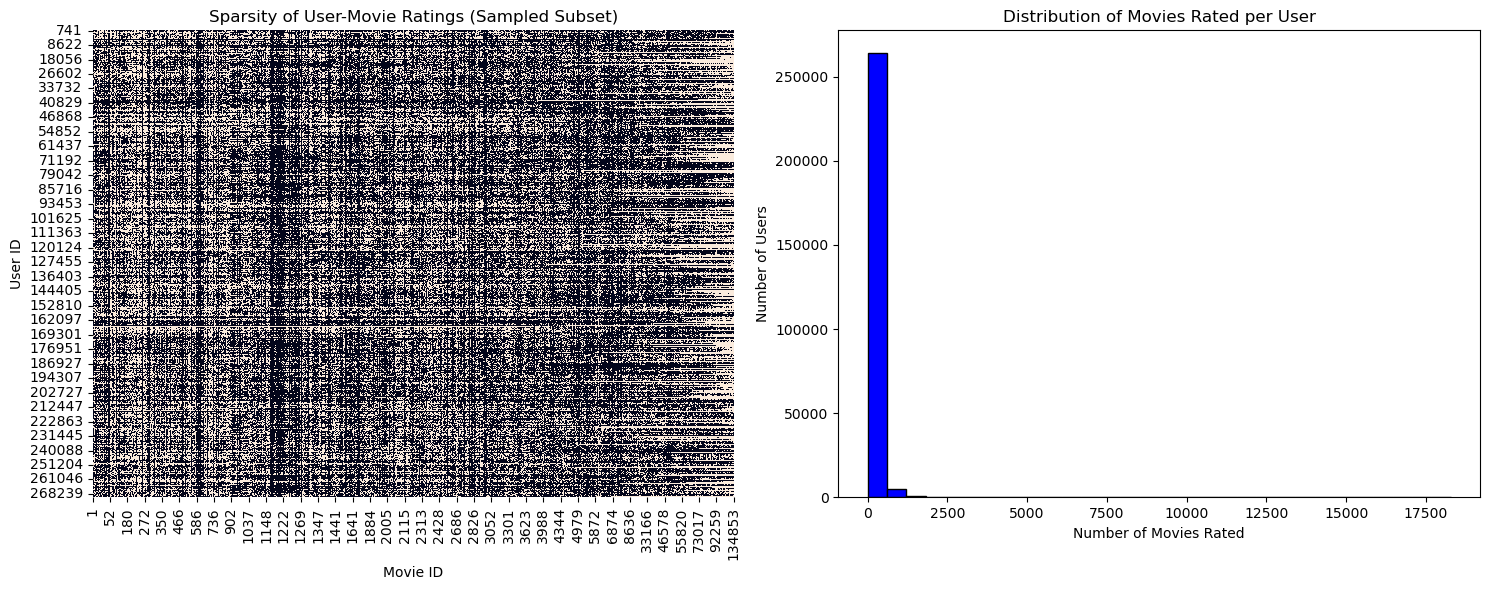

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix

# Assuming 'rating_df' DataFrame contains user IDs, movie IDs, and ratings
# Step 1: Compute sparsity without creating a dense matrix
n_users = rating_df['userId'].nunique()
n_movies = rating_df['movieId'].nunique()
n_ratings = len(rating_df)
total_possible_entries = n_users * n_movies
sparsity_percentage = (1 - (n_ratings / total_possible_entries)) * 100

# Display sparsity percentage
print(f"Number of unique users: {n_users}")
print(f"Number of unique movies: {n_movies}")
print(f"Number of ratings: {n_ratings}")
print(f"Total possible entries: {total_possible_entries:,}")
print(f"Sparsity percentage: {sparsity_percentage:.2f}%")

# Step 2: Subset for visualization (to avoid memory issues)
# Sample a small subset of users and movies for the heatmap
sample_size_users = 1000  # Number of users to sample
sample_size_movies = 1000  # Number of movies to sample

# Sample active users and top movies
user_count = rating_df['userId'].value_counts()
active_users = user_count.head(sample_size_users).index.tolist()  # Top 1000 users by rating count

movie_count = rating_df['movieId'].value_counts()
top_movies = movie_count.head(sample_size_movies).index.tolist()  # Top 1000 movies by rating count

# Filter the ratings to include only sampled users and movies
rating_subset = rating_df[
    (rating_df['userId'].isin(active_users)) & 
    (rating_df['movieId'].isin(top_movies))
]
print(f"Subset size for visualization: {len(rating_subset)} ratings")

# Create a small user-movie ratings matrix for the heatmap
user_movie_ratings = rating_subset.pivot_table(index='userId', columns='movieId', values='rating')

# Step 3: Create a side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Heatmap to visualize sparsity (on the subset)
sns.heatmap(user_movie_ratings.isnull(), cbar=False, ax=axes[0])
axes[0].set_xlabel("Movie ID")
axes[0].set_ylabel("User ID")
axes[0].set_title("Sparsity of User-Movie Ratings (Sampled Subset)")

# Histogram of movies rated per user (computed directly from raw data)
movies_rated_per_user = rating_df.groupby('userId')['movieId'].count()
axes[1].hist(movies_rated_per_user, bins=30, color="blue", edgecolor="black")
axes[1].set_xlabel("Number of Movies Rated")
axes[1].set_ylabel("Number of Users")
axes[1].set_title("Distribution of Movies Rated per User")

# Show the combined plot
plt.tight_layout()
plt.show()


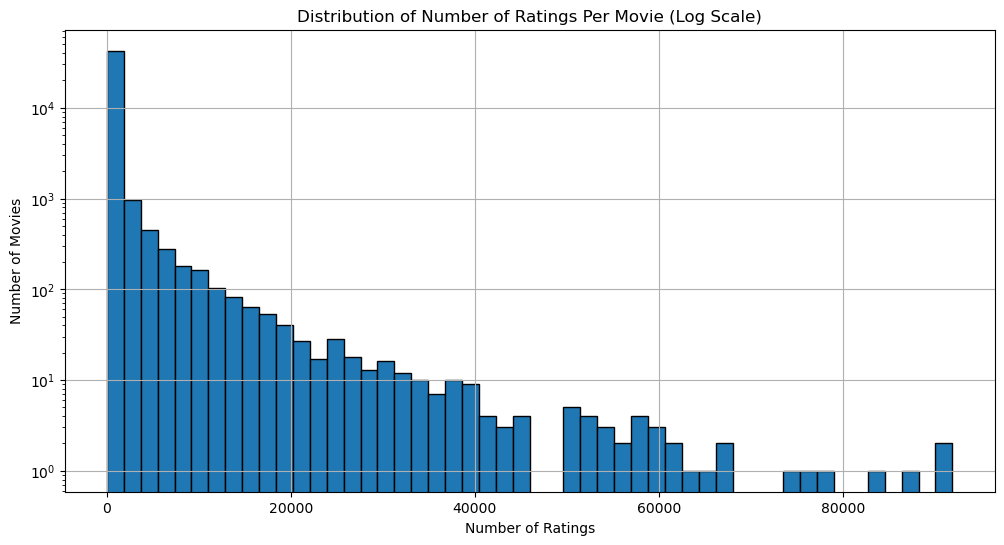

52.878200155159035

In [98]:
movie_rating_counts = rating_df.groupby('movieId').size().reset_index(name='num_ratings')

# Sort movies by number of ratings (descending)
movie_rating_counts = movie_rating_counts.sort_values(by='num_ratings', ascending=False)

# Plot the distribution of the number of ratings per movie
plt.figure(figsize=(12, 6))
plt.hist(movie_rating_counts['num_ratings'], bins=50, edgecolor='black', log=True)
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.title("Distribution of Number of Ratings Per Movie (Log Scale)")
plt.grid(True)
plt.show()

# Calculate the percentage of movies with fewer than 10 ratings
low_rating_movies = (movie_rating_counts['num_ratings'] < 10).sum()
low_rating_percentage = (low_rating_movies / len(movie_rating_counts)) * 100

low_rating_percentage

#### 2.5.1 Strategic Dataset Sampling

For a recommendation system to work effectively, we need both sufficient movie ratings and active users. We'll create a meaningful subset of the data by:

1. Focusing on popular movies (with at least 100 ratings)
2. Including only active users (those who rated at least 50 movies)
3. Balancing coverage and computational efficiency

This approach ensures our recommendation system has quality data to work with while remaining computationally feasible.

In [99]:
# Extract a meaningful subset from the full ratings dataset
# Strategy: Keep ratings from top users and for top movies to ensure good coverage

# 1. Identify top movies (most rated)
movie_count = rating_df['movieId'].value_counts()
top_movies = movie_count[movie_count >= 100].index.tolist()  # Movies with at least 100 ratings
print(f"Number of top movies (with 100+ ratings): {len(top_movies)}")

# 2. Identify active users (rated many movies)
user_count = rating_df['userId'].value_counts()
active_users = user_count[user_count >= 50].index.tolist()  # Users who rated at least 50 movies
print(f"Number of active users (rated 50+ movies): {len(active_users)}")

# 3. Filter the ratings to include only active users rating top movies
ratings_subset = rating_df[
    (rating_df['userId'].isin(active_users)) &
    (rating_df['movieId'].isin(top_movies))
]

print(f"Subset size: {len(ratings_subset)} ratings")
print(f"Number of unique users: {ratings_subset['userId'].nunique()}")
print(f"Number of unique movies: {ratings_subset['movieId'].nunique()}")

# If the subset is still very large, take a further sample
if len(ratings_subset) > 1000000:  # If more than 1 million ratings

    top_movie_ratings = ratings_subset.groupby('movieId').apply(
        lambda x: x.sample(min(len(x), 200))  # Take up to 200 ratings per movie
    ).reset_index(drop=True)

    # Then ensure we have ratings from all active users
    top_user_ratings = ratings_subset.groupby('userId').apply(
        lambda x: x.sample(min(len(x), 50))  # Take up to 50 ratings per user
    ).reset_index(drop=True)

    # Combine and remove duplicates
    combined_ratings = pd.concat([top_movie_ratings, top_user_ratings])
    ratings_subset = combined_ratings.drop_duplicates(subset=['userId', 'movieId'])

    print(f"Further sampled subset size: {len(ratings_subset)} ratings")

# Replace the original ratings dataset with our subset
ratings = ratings_subset

# Display the sampled ratings
print("\nSample of the ratings subset:")
ratings.head()

# Define the output file path
output_file = 'filtered_ratings.csv'

# Export the filtered ratings to CSV
ratings.to_csv(output_file, index=False)
print(f"Filtered ratings dataset has been saved to {output_file}")
print(f"File size: {os.path.getsize(output_file) / (1024*1024):.2f} MB")




Number of top movies (with 100+ ratings): 9976
Number of active users (rated 50+ movies): 103839
Subset size: 22445991 ratings
Number of unique users: 103839
Number of unique movies: 9976
Further sampled subset size: 6749644 ratings

Sample of the ratings subset:
Filtered ratings dataset has been saved to filtered_ratings.csv
File size: 235.31 MB


In [100]:
import os

filtered_ratings_path = 'filtered_ratings.csv'

def load_ratings():
    """Load ratings dataset, either from filtered file if exists or process the full dataset"""
    if os.path.exists(filtered_ratings_path):
        print(f"Loading pre-filtered ratings from {filtered_ratings_path}")
        return pd.read_csv(filtered_ratings_path)
    else:
        print("Filtered ratings file not found. Please run the data processing steps first.")
        return None

# Load the filtered ratings dataset
filtered_ratings_df = load_ratings()

Loading pre-filtered ratings from filtered_ratings.csv


In [101]:
# Create the bins and labels
step_size = 200
bins = [0] + list(range(50, 3000 + step_size, step_size)) + [float('inf')]
labels = [f'{bins[i]}-{bins[i+1] - 1}' if bins[i+1] != float('inf') else f'{bins[i]}+' for i in range(len(bins)-1)]

# Calculate the number of ratings per user for both datasets
num_movies_per_user_combined = rating_df.groupby('userId').size()
num_movies_per_user_filtered = filtered_ratings_df.groupby('userId').size()

# Categorize users based on the number of movies they rated for combined data
rating_categories_combined = pd.cut(num_movies_per_user_combined, bins=bins, labels=labels)

# Categorize users based on the number of movies they rated for filtered data
rating_categories_filtered = pd.cut(num_movies_per_user_filtered, bins=bins, labels=labels)

# Count the number of users in each category for both datasets
rating_categories_counts_combined = rating_categories_combined.value_counts().reindex(labels)
rating_categories_counts_filtered = rating_categories_filtered.value_counts().reindex(labels)

# Combine the counts into a single DataFrame for comparison
rating_counts_table = pd.DataFrame({
    'Combined Data': rating_categories_counts_combined,
    'Reduced Data': rating_categories_counts_filtered
})

print("User counts in each rating category:")
rating_counts_table


User counts in each rating category:


,Combined Data,Reduced Data
0-49,168517,23858
50-249,77180,78996
250-449,14074,712
450-649,5220,160
650-849,2417,59
850-1049,1283,29
1050-1249,831,11
1250-1449,476,4
1450-1649,274,4
1650-1849,169,2


## 3. Merging All Our Data

In [102]:
keywords_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            46419 non-null  int64 
 1   keywords      46419 non-null  object
 2   keywords_str  46419 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [103]:
# Merge keywords with movie metadata on 'id'
# Convert 'id' to numeric in all datasets for consistency
keywords_df['id'] = pd.to_numeric(keywords_df['id'], errors='coerce')
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce')
credits_df['id'] = pd.to_numeric(credits_df['id'], errors='coerce')

# Merge all three datasets on 'id'
merged_df = movies_df.merge(keywords_df, on='id', how='inner').merge(credits_df, on='id', how='inner')


In [104]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41654 entries, 0 to 41653
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  41654 non-null  int64         
 1   belongs_to_collection  41654 non-null  object        
 2   budget                 41654 non-null  object        
 3   genres                 41654 non-null  object        
 4   id                     41654 non-null  int32         
 5   imdb_id                41654 non-null  object        
 6   original_language      41654 non-null  object        
 7   original_title         41654 non-null  object        
 8   overview               41654 non-null  object        
 9   popularity             41654 non-null  float64       
 10  production_companies   41654 non-null  object        
 11  production_countries   41654 non-null  object        
 12  release_date           41654 non-null  datetime64[ns]
 13  r

In [105]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41654 entries, 0 to 41653
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  41654 non-null  int64         
 1   belongs_to_collection  41654 non-null  object        
 2   budget                 41654 non-null  object        
 3   genres                 41654 non-null  object        
 4   id                     41654 non-null  int32         
 5   imdb_id                41654 non-null  object        
 6   original_language      41654 non-null  object        
 7   original_title         41654 non-null  object        
 8   overview               41654 non-null  object        
 9   popularity             41654 non-null  float64       
 10  production_companies   41654 non-null  object        
 11  production_countries   41654 non-null  object        
 12  release_date           41654 non-null  datetime64[ns]
 13  r

We will use a script to scrape the keywords from TMDB using an API to fill out as many empty keywords as possible

In [106]:
# Define the values to filter out in the 'overview' column
filter_values = ["no overview", "no overview yet", "No overview found."]

# Remove rows containing these values in the 'overview' column
merged_df = merged_df[~merged_df['overview'].isin(filter_values)]

In [107]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41292 entries, 0 to 41653
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  41292 non-null  int64         
 1   belongs_to_collection  41292 non-null  object        
 2   budget                 41292 non-null  object        
 3   genres                 41292 non-null  object        
 4   id                     41292 non-null  int32         
 5   imdb_id                41292 non-null  object        
 6   original_language      41292 non-null  object        
 7   original_title         41292 non-null  object        
 8   overview               41292 non-null  object        
 9   popularity             41292 non-null  float64       
 10  production_companies   41292 non-null  object        
 11  production_countries   41292 non-null  object        
 12  release_date           41292 non-null  datetime64[ns]
 13  revenu

In [108]:
import re
# Remove any 1, 2, or 3-digit numbers from the 'keywords' column
merged_df['keywords'] = merged_df['keywords'].astype(str).apply(lambda x: re.sub(r'\b\d{1,3}\b', '', x))

In [109]:
duplicateCheck = merged_df.duplicated(subset=['id'],keep='last')

print('No. of duplicates: {}'.format(len(merged_df[duplicateCheck])))
print()
print(merged_df[duplicateCheck]['id'])

No. of duplicates: 934

650      105045
651      105045
652      105045
902       22649
903       22649
          ...  
41133     12600
41134     12600
41491    265189
41492    265189
41493    265189
Name: id, Length: 934, dtype: int32


In [110]:
merged_df = merged_df.drop_duplicates(subset=['id'], keep='last')

In [111]:
merged_df.head()

,adult,belongs_to_collection,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,genres_list,genres_str,has_collection,has_overview,has_homepage,has_tagline,has_poster,keywords,keywords_str,cast,crew,Cast,Director
0,0,Toy Story Collection,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,1995-10-30,373554033.0,81.0,English,Toy Story,7.7,5415.0,"[Animation, Comedy, Family]","Animation, Comedy, Family",1,1,1,0,1,"[{'id': , 'name': 'jealousy'}, {'id': 4290, 'n...",jealousy toy boy friendship friends rivalry bo...,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter
1,0,no collection,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,1995-12-15,262797249.0,104.0,"English, Français",Jumanji,6.9,2413.0,"[Adventure, Fantasy, Family]","Adventure, Fantasy, Family",0,1,0,1,1,"[{'id': 10090, 'name': 'board game'}, {'id': 1...",boardgame disappearance basedonchildren'sbook ...,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston
2,0,Grumpy Old Men Collection,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"Warner Bros., Lancaster Gate",United States of America,1995-12-22,0.0,101.0,English,Grumpier Old Men,6.5,92.0,"[Romance, Comedy]","Romance, Comedy",1,1,0,1,1,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",fishing bestfriend duringcreditsstinger oldmen,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch
3,0,no collection,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,1995-12-22,81452156.0,127.0,English,Waiting to Exhale,6.1,34.0,"[Comedy, Drama, Romance]","Comedy, Drama, Romance",0,1,0,1,1,"[{'id': , 'name': 'based on novel'}, {'id': 10...",basedonnovel interracialrelationship singlemot...,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker
4,0,Father of the Bride Collection,0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,1995-02-10,76578911.0,106.0,English,Father of the Bride Part II,5.7,173.0,[Comedy],Comedy,1,1,0,1,1,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",baby midlifecrisis confidence aging daughter m...,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer


In [112]:
print(merged_df.isna().sum())

adult                      0
belongs_to_collection      0
budget                     0
genres                     0
id                         0
imdb_id                    0
original_language          0
original_title             0
overview                   0
popularity                 0
production_companies       0
production_countries       0
release_date               0
revenue                    0
runtime                    0
spoken_languages           0
title                      0
vote_average               0
vote_count                 0
genres_list                0
genres_str                 0
has_collection             0
has_overview               0
has_homepage               0
has_tagline                0
has_poster                 0
keywords                   0
keywords_str               0
cast                       0
crew                       0
Cast                       0
Director                 397
dtype: int64


In [113]:
merged_df.loc[merged_df['Director'].isnull(),'Director'] = 'no director'

#### Scrapping data from TMBD to get missing keywords
- Note: This needs an API KEY, so we have provided the extracted dataset

- Here: https://sitsingaporetechedu-my.sharepoint.com/:f:/g/personal/2400788_sit_singaporetech_edu_sg/Ejq4J52gzidJs3D7_XYEXaEBmzwTdZL0pH4fHxHlNJ_9fg?e=r1fqub

In [135]:
# movies_df = fill_empty_value(movies_df)
movies_df = pd.read_csv("movies_tuned.csv")

In [155]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41640 entries, 0 to 41639
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  41640 non-null  int64  
 1   belongs_to_collection  41640 non-null  object 
 2   budget                 41640 non-null  int64  
 3   genres                 41640 non-null  object 
 4   id                     41640 non-null  int64  
 5   imdb_id                41640 non-null  object 
 6   original_language      41640 non-null  object 
 7   original_title         41640 non-null  object 
 8   overview               41640 non-null  object 
 9   popularity             41640 non-null  float64
 10  production_companies   32208 non-null  object 
 11  production_countries   37077 non-null  object 
 12  release_date           41640 non-null  object 
 13  revenue                41640 non-null  float64
 14  runtime                41640 non-null  float64
 15  sp

## 4. Data Analysis

### 4.1 Movie Language Consistency -> Do audiences watch movies of only 1 particular language? (to confirm and change)

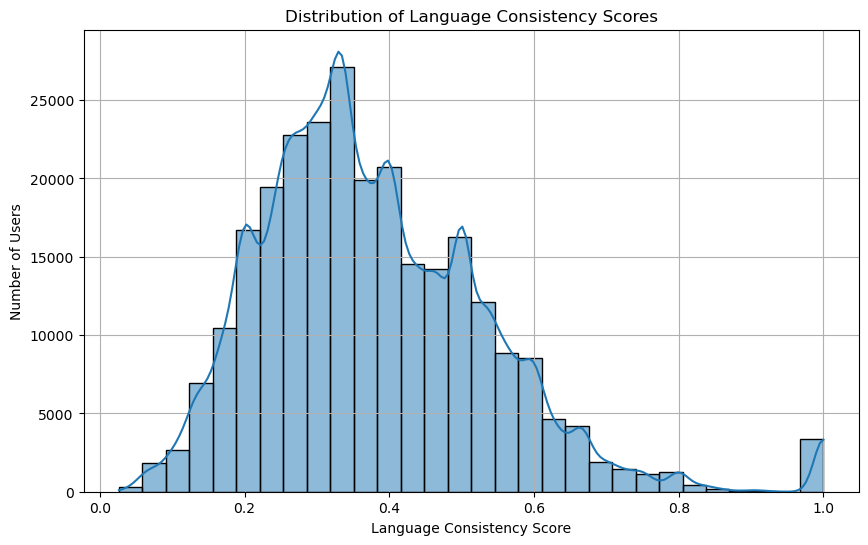

In [136]:
ratings_languages = pd.merge(
    rating_df,
    merged_df[['id', 'original_language']],
    left_on='movieId',
    right_on='id',
    how='left'
)

# Calculate language consistency score
user_language_counts = ratings_languages.groupby(['userId', 'original_language']).size().reset_index(name='count')
max_language_counts = user_language_counts.loc[user_language_counts.groupby('userId')['count'].idxmax()]
total_counts = ratings_languages.groupby('userId').size().reset_index(name='total')

language_consistency_score = pd.merge(max_language_counts, total_counts, on='userId')
language_consistency_score['consistency_score'] = language_consistency_score['count'] / language_consistency_score['total']

# Plot the consistency score distribution
plt.figure(figsize=(10, 6))
sns.histplot(language_consistency_score['consistency_score'], bins=30, kde=True)
plt.title('Distribution of Language Consistency Scores')
plt.xlabel('Language Consistency Score')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()



The above graph shows the main language consistency. We want to know if users tends to watch movies from the same language.

We calculate purity of the of the watch list of every user and calculate how many of the watch list in terms of percentage consist of only 1 language.

From the graph, we can see the languages are varied. However, there are still plenty of people watching movies exclusively (check) in their native language. This can be a strong detemining factor in our recommender system.

In [137]:
merged_df["original_language"].isna().sum()

0

In [138]:
ratings_languages.isna().sum()

userId                      0
movieId                     0
rating                      0
timestamp                   0
id                   14765504
original_language    14765504
dtype: int64

### 4.2 Distibution of genre consistency score -> How consistent are audience watch list? Do they often watch movies of the same genre?

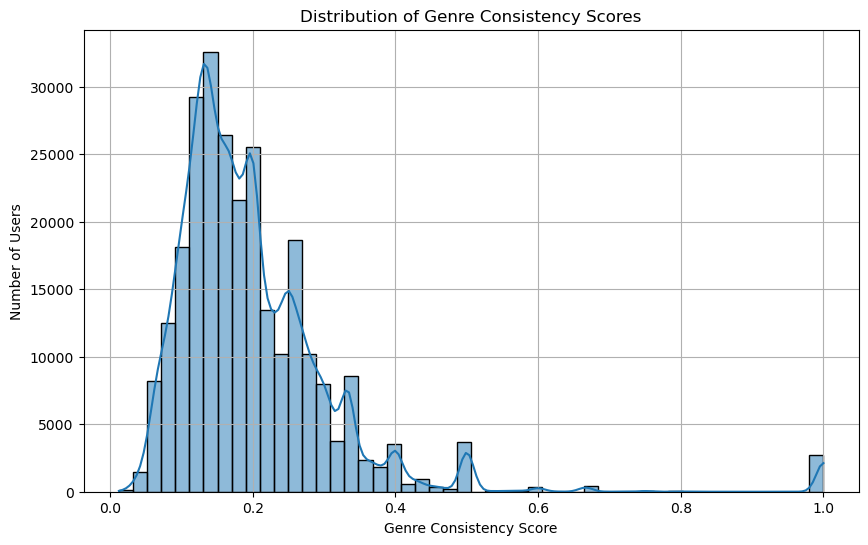

In [139]:
try:
  # Extract genres
  movies_df['genres'] = movies_df['genres'].apply(
      lambda x: [x.split(", ")[0]] if pd.notnull(x) else []
  )
except:
  pass

# Expand genres
movies_genres_expanded = movies_df.explode('genres')

# Merge with ratings
ratings_genres = pd.merge(
    rating_df, movies_genres_expanded[['id', 'genres']],
    left_on='movieId', right_on='id', how='left'
)

# Calculate genre consistency score
user_genre_counts = ratings_genres.groupby(['userId', 'genres']).size().reset_index(name='count')
max_genre_counts = user_genre_counts.loc[user_genre_counts.groupby('userId')['count'].idxmax()]
total_genre_counts = ratings_genres.groupby('userId').size().reset_index(name='total')

genre_consistency_score = pd.merge(max_genre_counts, total_genre_counts, on='userId')
genre_consistency_score['genre_consistency_score'] = genre_consistency_score['count'] / genre_consistency_score['total']

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(genre_consistency_score['genre_consistency_score'], bins=50, kde=True)
plt.title('Distribution of Genre Consistency Scores')
plt.xlabel('Genre Consistency Score')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()

This graph shows how consistent an user's watchlist is. The above chart takes the first genre of the movies from the Genre column. The char allows us to see the percent purity of the watch list.

The chart indicates that the genre of movies audiences watch are often varied. The data will be clearer if more genres are taken into consideration.

### 4.3 Distributiuon of vote count -> How is the vote count distributed among all the movies?

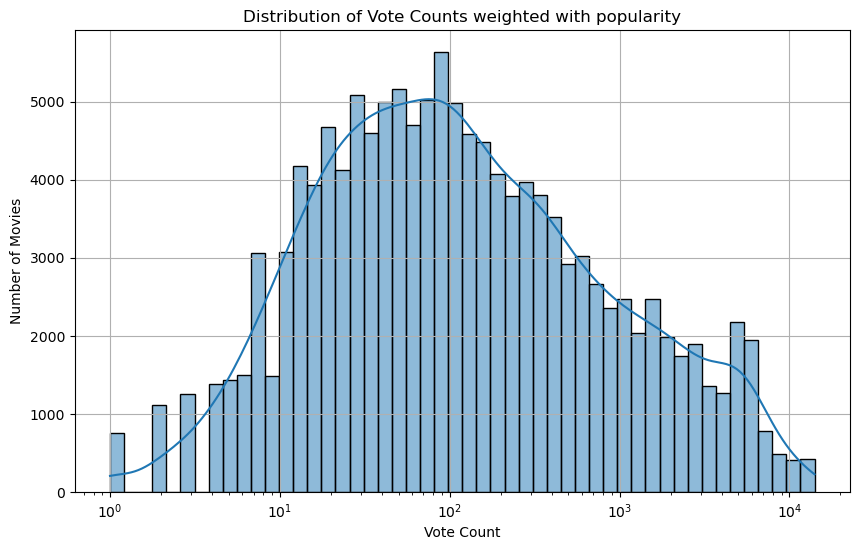

In [140]:
# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(data=movies_df, x='vote_count',  weights='popularity', bins=50, log_scale=(True, False), kde=True)
plt.title('Distribution of Vote Counts weighted with popularity')
plt.xlabel('Vote Count')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

From the above chart, we analyze the distribution of the number of votes against the number of movies using popularity as the weight.

From the graph, we can clearly see that, movies with higher popularity are contributing more weight to the bins above 10^1 (10). The peak of the chart appears to be around 10^2 and 10^3 (100 to 1000) meaning movies with moderate to high vote counts contribute the most to the total popularity. Movies with very low vote count have very low popularity scores. The right skewed movies contributes significantly but are lower in number.

Considering the number of movies weighted by popularity score, we most likely be able to remove movies that are below the 75th percentile, around 10^1 (10) votes.


### 4.4 Distributiuon of vote average -> What is the distribution of the average score of movies in the dataset?

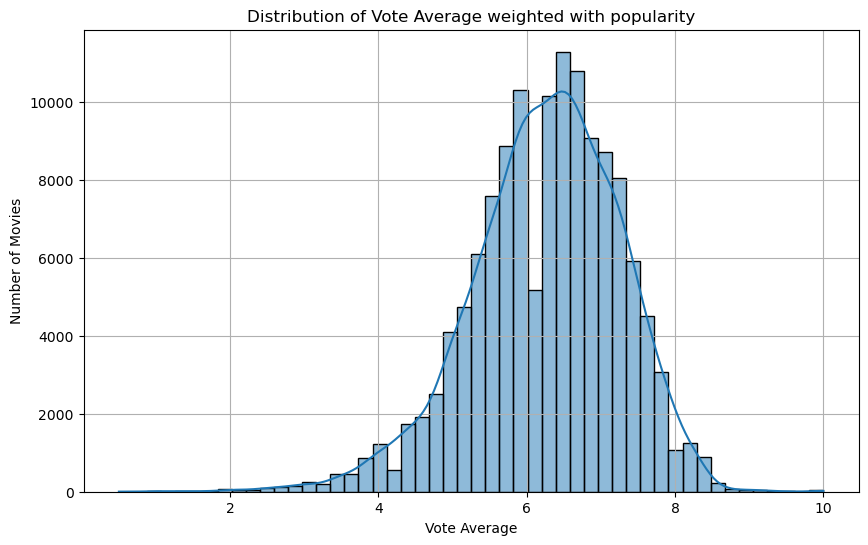

In [141]:
# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(data=movies_df, x='vote_average',  weights='popularity', bins=50, kde=True)
plt.title('Distribution of Vote Average weighted with popularity')
plt.xlabel('Vote Average')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

### 4.5 Movie popularity correlation with quality (weighted_rating) -> Do higher-rated movies tend to be more popular?

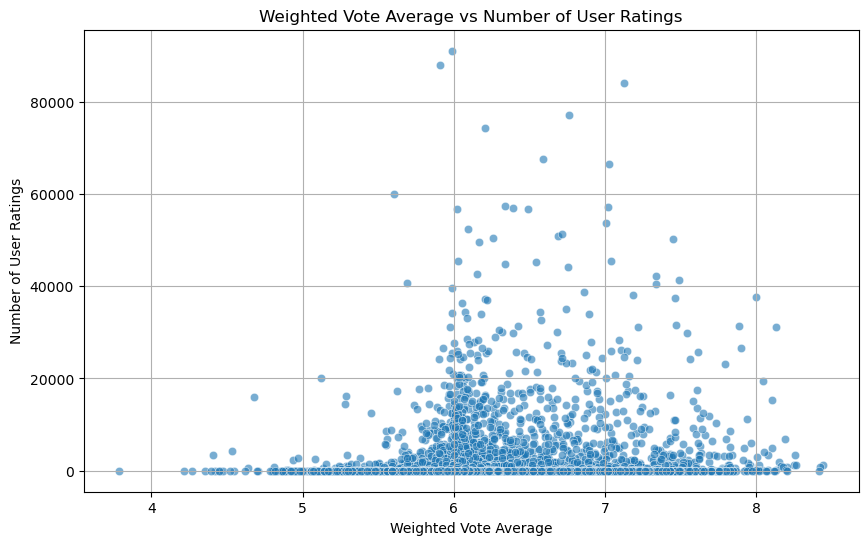

In [142]:
# Compute IMDB-style weighted rating
C = movies_df['vote_average'].mean()  # Mean vote average across all movies
m = movies_df['vote_count'].quantile(0.90)  # Minimum vote count threshold (90th percentile)

# Calculate weighted rating using IMDB formula
movies_df['weighted_rating'] = ((movies_df['vote_count'] / (movies_df['vote_count'] + m)) * movies_df['vote_average'] +
                                (m / (movies_df['vote_count'] + m)) * C)

# Compute the number of user ratings per movie
rating_counts = rating_df.groupby('movieId').size().reset_index(name='num_user_ratings')

# Merge with movies_df
movies_ratings_weighted = pd.merge(movies_df, rating_counts, left_on='id', right_on='movieId', how='left').fillna(0)

# Plot Weighted Vote Average vs. Number of User Ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x='weighted_rating', y='num_user_ratings', data=movies_ratings_weighted, alpha=0.6)
plt.title('Weighted Vote Average vs Number of User Ratings')
plt.xlabel('Weighted Vote Average')
plt.ylabel('Number of User Ratings')
plt.grid(True)
plt.show()

From the visualization, we can see that most movies have a weighted rating between 5 and 7, but their number of user ratings varies widely.

A key observation is that movies with high user engagement (many ratings) are not necessarily the highest-rated. While some of the most popular movies (those with over 200 user ratings) have ratings in the 6-7 range, there are very few highly rated movies (above 8) that also have a high number of user ratings. This suggests that quality and popularity do not always go hand in hand—a well-rated movie does not automatically receive more ratings, and a highly rated film may not necessarily be widely seen.

### 4.6 Relationship Between Movie Popularity and User Engagement -> Is there a relationship between a movie's popularity score and the number of user ratings it receives?

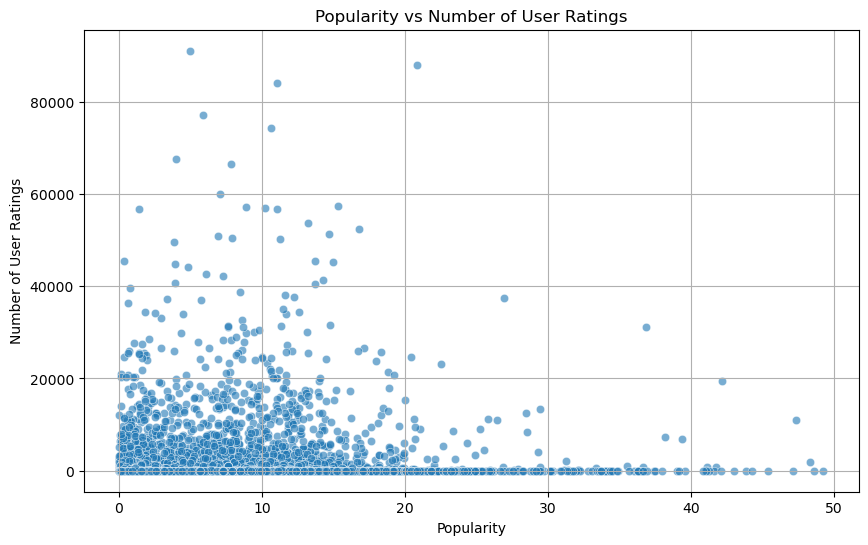

In [143]:
# Merge movies popularity with number of user ratings
movies_popularity = pd.merge(movies_df, rating_counts, left_on='id', right_on='movieId', how='left').fillna(0)

# Zoom into lower popularity
movies_popularity['popularity'] = pd.to_numeric(movies_popularity['popularity'], errors='coerce')

movies_popularity = movies_popularity[movies_popularity['popularity'] < 50]

# Plot popularity vs number of user ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x='popularity', y='num_user_ratings', data=movies_popularity, alpha=0.6)
plt.title('Popularity vs Number of User Ratings')
plt.xlabel('Popularity')
plt.ylabel('Number of User Ratings')
plt.grid(True)
plt.show()

While there is some relationship between a movie's popularity score and the number of user ratings, it is not a strong or direct one. Many movies with low popularity scores still receive a significant number of ratings, while some highly popular movies do not necessarily have high user engagement. The majority of data points are clustered toward the lower end of the popularity scale, suggesting that most movies are relatively obscure.

However, there are a few standout films with both high popularity and a large number of ratings, indicating that certain movies achieve both broad visibility and audience engagement.

### 4.7 Movie release trends -> Does the time of release affect movie popularity and ratings? How many movies are released in a season/year?

In [144]:
# create a new column called year to store year of release for movies
merged_df['year'] = pd.to_datetime(merged_df['release_date']).dt.year

# Function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

merged_df['season'] = merged_df['release_date'].dt.month.apply(get_season)

# create a new column called month to store month of release for movies
merged_df['month'] = pd.to_datetime(merged_df['release_date']).dt.month

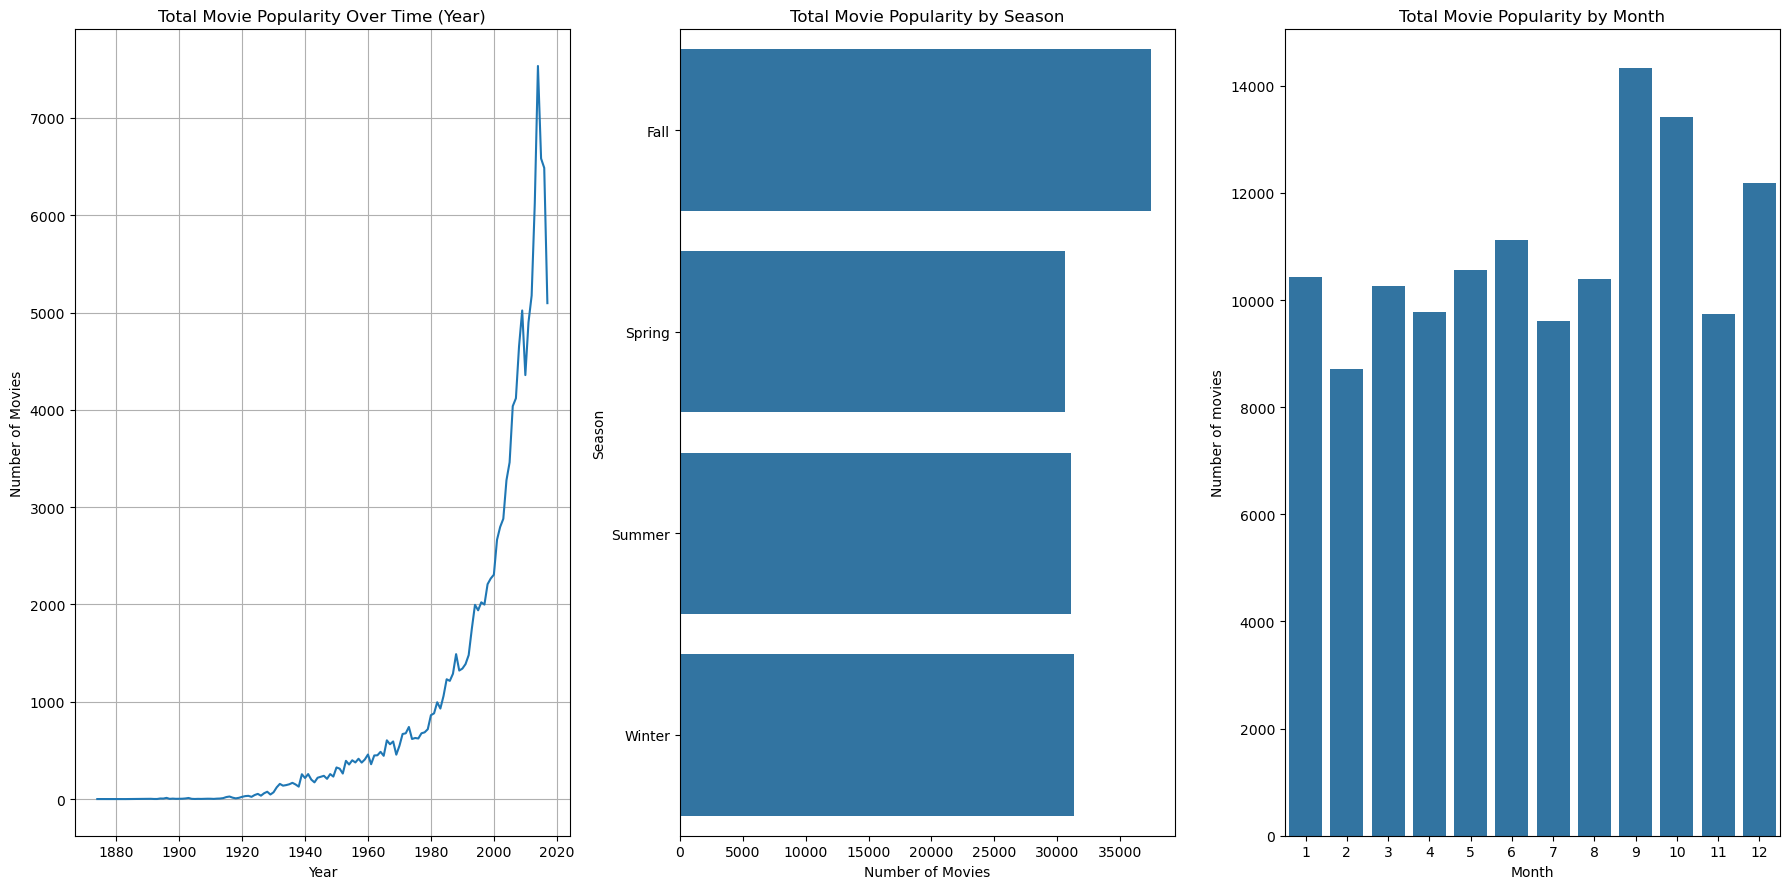

In [145]:
# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 9))

# 1. Line chart of movie releases over the years
yearly_popularity = merged_df.groupby('year')['popularity'].sum()
sns.lineplot(x=yearly_popularity.index, y=yearly_popularity.values, ax=axes[0])
axes[0].set_title('Total Movie Popularity Over Time (Year)')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Movies')
axes[0].grid(True)

# 2. Bar chart of movie releases by season
season_popularity = merged_df.groupby('season')['popularity'].sum()
sns.barplot(x=season_popularity.values, y=season_popularity.index, ax=axes[1])
axes[1].set_title('Total Movie Popularity by Season')
axes[1].set_xlabel('Number of Movies')
axes[1].set_ylabel('Season')

# 3. Bar chart of movie releases by month
month_popularity = merged_df.groupby('month')['popularity'].sum()
sns.barplot(x=month_popularity.index, y=month_popularity.values, ax=axes[2])
axes[2].set_title('Total Movie Popularity by Month')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Number of movies')

# Adjust layout
plt.tight_layout()
plt.show()

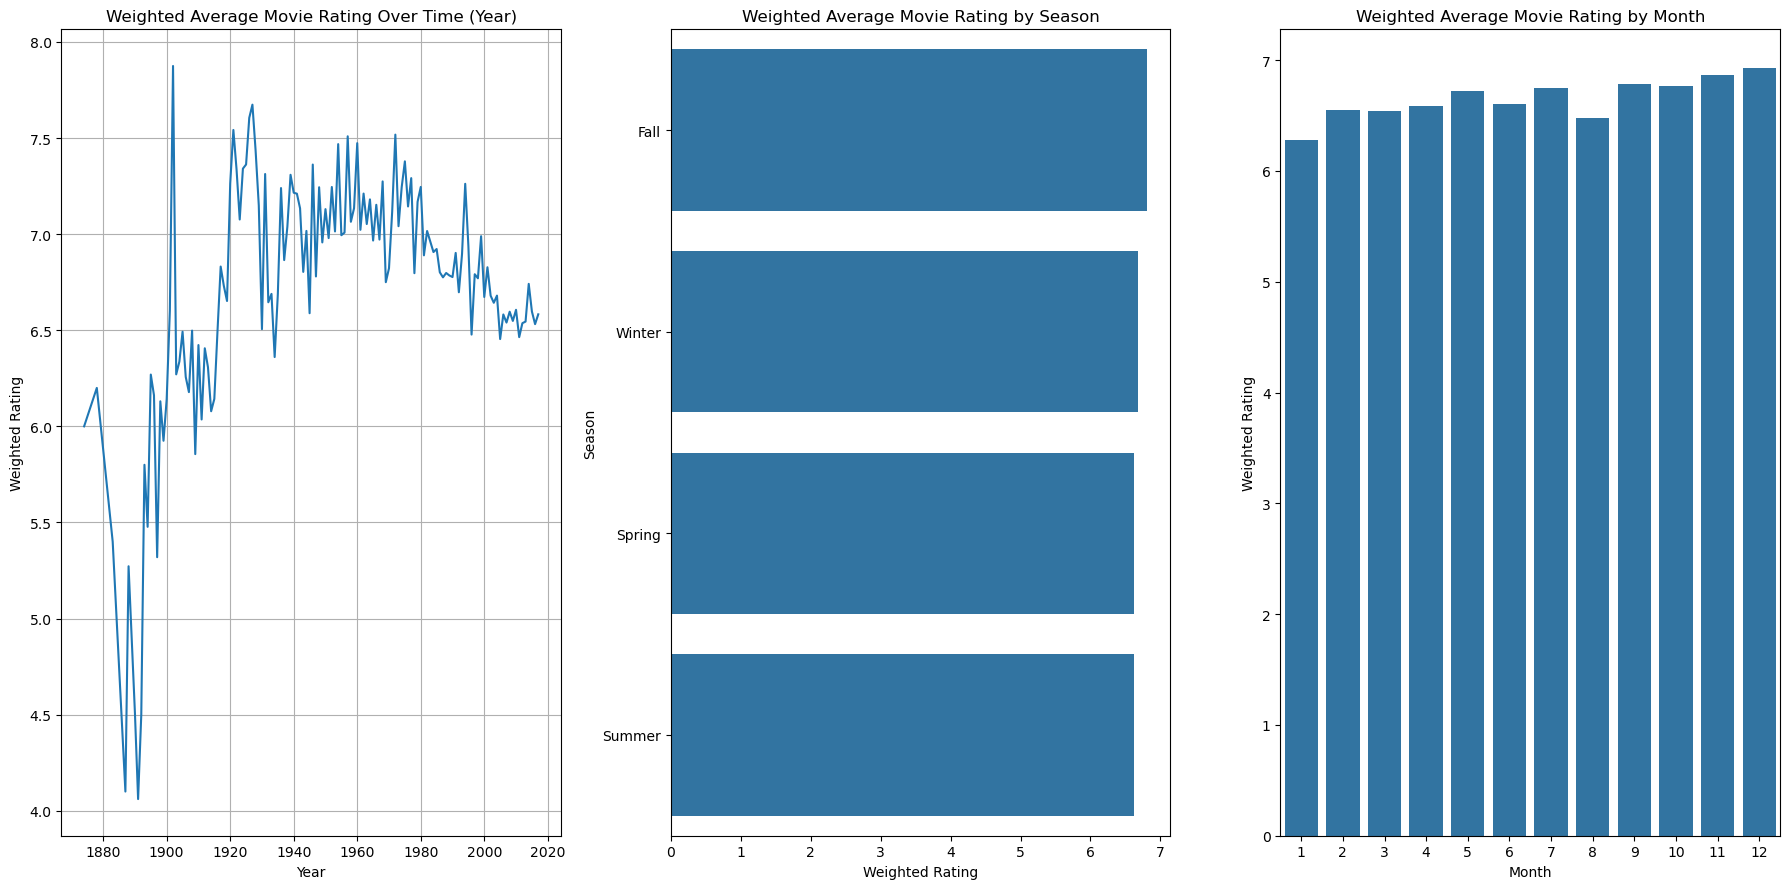

In [146]:
# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 9))

# 1. Line chart of movie releases over the years
yearly_ratings = merged_df.groupby('year').apply(lambda x: (x['vote_average'] * x['vote_count']).sum() / x['vote_count'].sum())
sns.lineplot(x=yearly_ratings.index, y=yearly_ratings.values, ax=axes[0])
axes[0].set_title('Weighted Average Movie Rating Over Time (Year)')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Weighted Rating')
axes[0].grid(True)

# 2. Bar chart of movie releases by season
season_ratings = merged_df.groupby('season').apply(lambda x: (x['vote_average'] * x['vote_count']).sum() / x['vote_count'].sum()).sort_values(ascending=False)
sns.barplot(x=season_ratings.values, y=season_ratings.index, ax=axes[1])
axes[1].set_title('Weighted Average Movie Rating by Season')
axes[1].set_xlabel('Weighted Rating')
axes[1].set_ylabel('Season')

# 3. Bar chart of movie releases by month
month_ratings = merged_df.groupby('month').apply(lambda x: (x['vote_average'] * x['vote_count']).sum() / x['vote_count'].sum()).sort_values(ascending=False)
sns.barplot(x=month_ratings.index, y=month_ratings.values, ax=axes[2])
axes[2].set_title('Weighted Average Movie Rating by Month')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Weighted Rating')

# Adjust layout
plt.tight_layout()
plt.show()

### 4.8 What are the top production companies. Does producitons companies have a huge effect on popularity and vote?

In [147]:
companies_df = merged_df[['id', 'title', 'production_companies', 'popularity', 'vote_average', 'vote_count', 'revenue']].copy()

companies_df['production_companies'] = companies_df['production_companies'].apply(lambda x: x.split(', '))
companies_df = companies_df.explode('production_companies')

companies_df = companies_df.groupby('production_companies').agg({
    'popularity': 'mean',
    'vote_average': 'mean',
    'vote_count': 'sum',
    'revenue': 'sum',
    'id': 'nunique'
}).rename(columns={'id': 'unique_movies'}).reset_index()

companies_df['production_companies'] = companies_df['production_companies'].replace(['', ' '], 'No Production Company').fillna('No Production Company')

companies_df = companies_df.sort_values(by='unique_movies', ascending=False)

companies_df.head()

,production_companies,popularity,vote_average,vote_count,revenue,unique_movies
0,No Production Company,1.051277,5.933455,88860.0,1.635499e+09,9006
21488,Warner Bros.,6.588462,6.178571,565925.0,6.352519e+10,1176
12928,Metro-Goldwyn-Mayer (MGM),3.170417,6.023187,106332.0,1.237679e+10,979
14991,Paramount Pictures,5.872702,6.142931,371011.0,4.876810e+10,962
20900,Universal Pictures,7.854989,6.177914,405025.0,5.525919e+10,815


Text(0, 0.5, 'Production Companies')

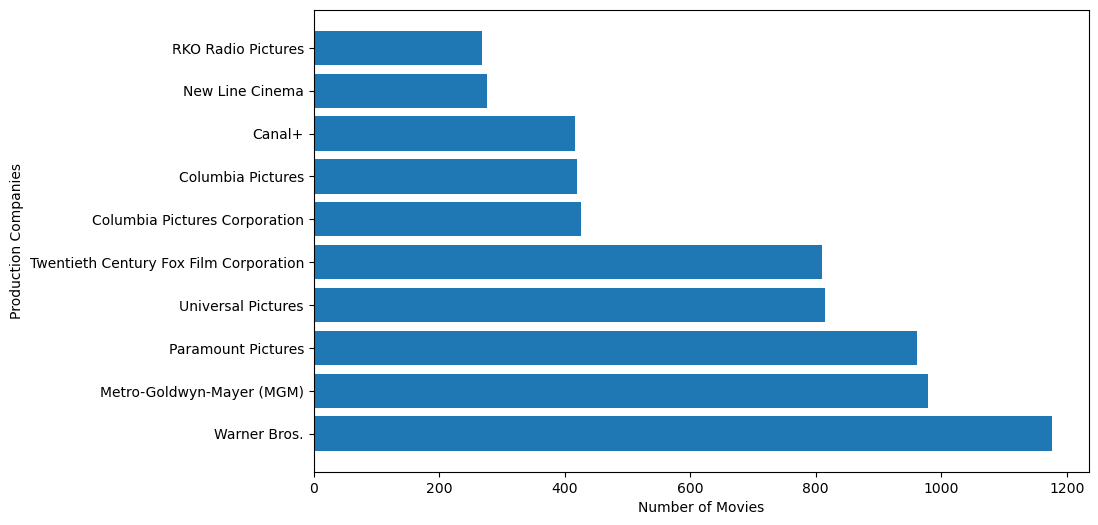

In [148]:
# Create a horizontal barchart for the top 10 production companies excluding 'no production companies'
top_companies = companies_df[companies_df['production_companies'] != 'No Production Company'].head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_companies['production_companies'], top_companies['unique_movies'])
plt.xlabel('Number of Movies')
plt.ylabel('Production Companies')

### 4.9 What are the most popular genres?

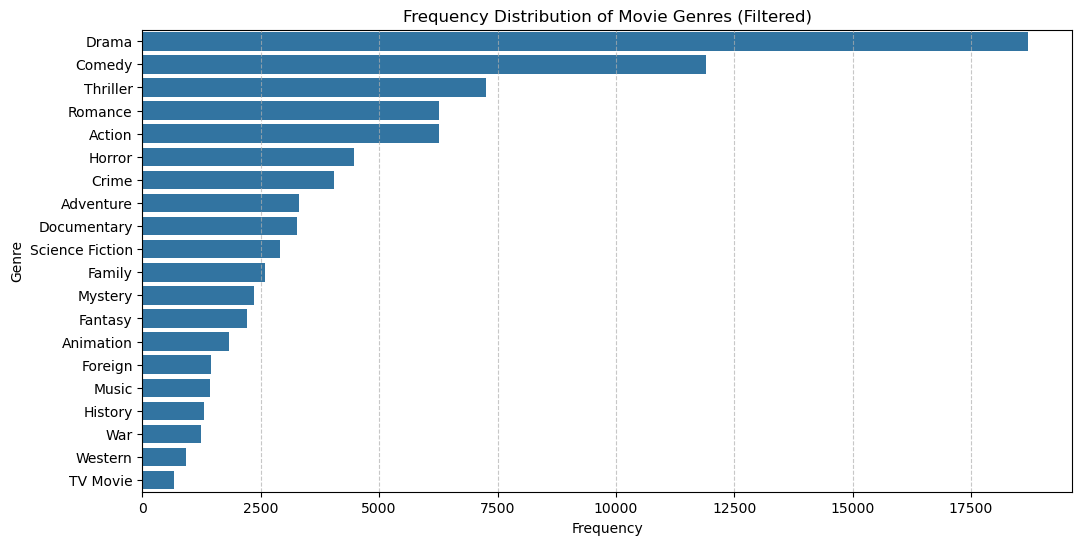

In [149]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract and process genres
all_genres = merged_df['genres_str'].dropna().str.split(', ').sum()
genre_counts = Counter(all_genres)

# Convert to DataFrame for visualization
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Filter out empty or invalid genre entries
filtered_genre_df = genre_df[genre_df['Genre'].str.strip() != ""]

# Plot the updated frequency distribution with flipped axes
plt.figure(figsize=(12, 6))
sns.barplot(y=filtered_genre_df['Genre'], x=filtered_genre_df['Count'])
plt.xlabel("Frequency")
plt.ylabel("Genre")
plt.title('Frequency Distribution of Movie Genres (Filtered)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


### 4.10 Director Influence on Ratings & Popularity



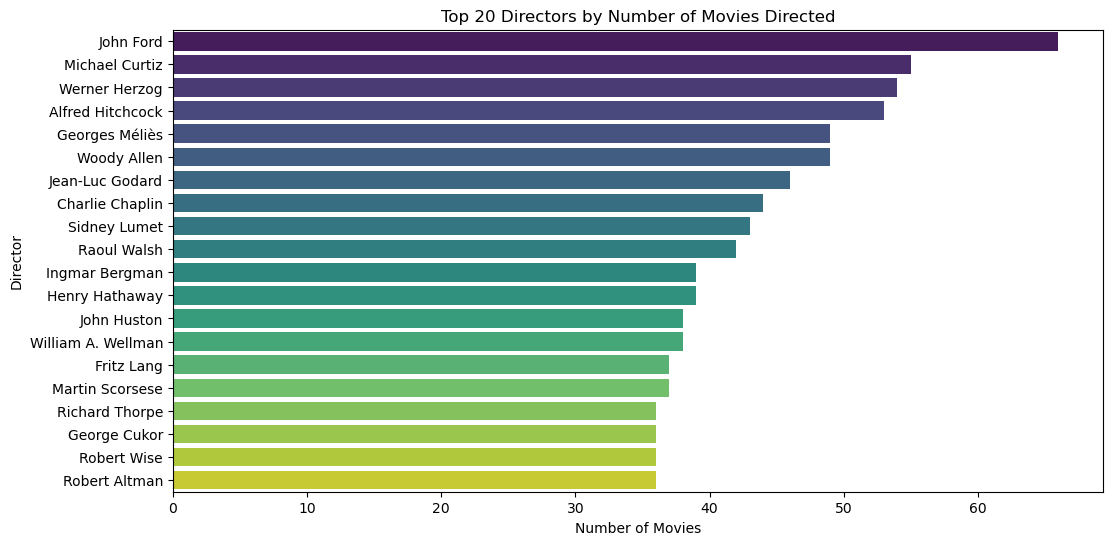

In [150]:
# Remove rows where Director is "no director"
filtered_directors_df = merged_df[merged_df["Director"].str.lower() != "no director"]

# Count the number of movies per director
director_movie_count = filtered_directors_df["Director"].value_counts().head(20)  # Top 20 directors

# Plot the director vs. movie count
plt.figure(figsize=(12, 6))
sns.barplot(x=director_movie_count.values, y=director_movie_count.index, palette="viridis")
plt.xlabel("Number of Movies")
plt.ylabel("Director")
plt.title("Top 20 Directors by Number of Movies Directed")
plt.show()


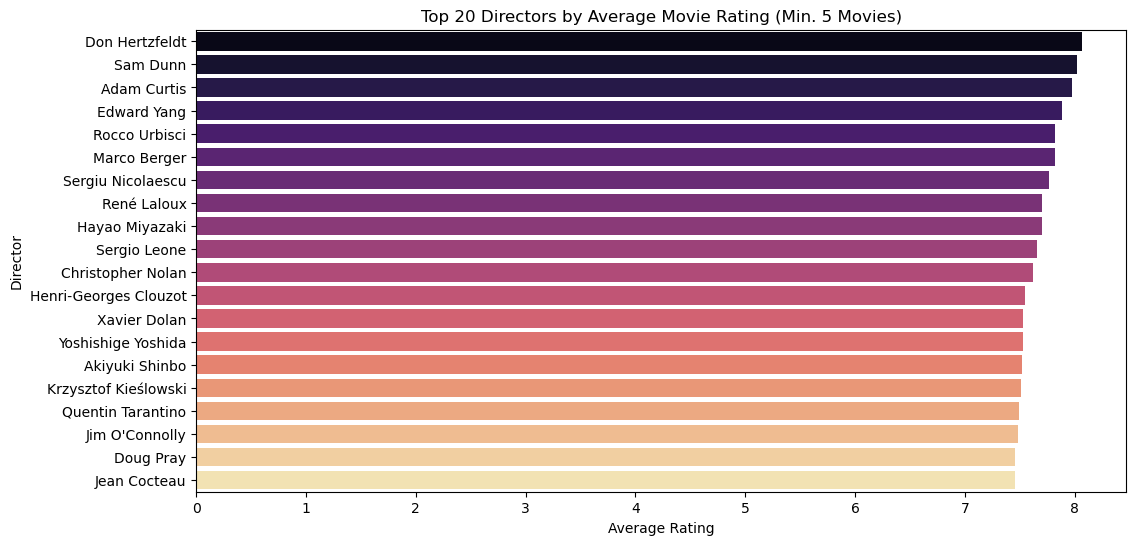

In [151]:
# Count number of movies per director
director_movie_counts = merged_df.groupby('Director').size().reset_index(name='movie_count')

# Merge with average rating data
director_rating_df = merged_df.groupby('Director')['vote_average'].mean().reset_index()
director_rating_df = director_rating_df.merge(director_movie_counts, on='Director')

# Filter directors with at least 5 movies
filtered_directors = director_rating_df[director_rating_df['movie_count'] >= 5]

# Sort by rating and select top 20 directors
top_directors_filtered = filtered_directors.sort_values(by='vote_average', ascending=False).head(20)

# Plot the corrected graph
plt.figure(figsize=(12, 6))
sns.barplot(x=top_directors_filtered['vote_average'], y=top_directors_filtered['Director'], palette='magma')
plt.xlabel("Average Rating")
plt.ylabel("Director")
plt.title("Top 20 Directors by Average Movie Rating (Min. 5 Movies)")
plt.show()


### 4.11 Genre Influence on Ratings & Popularity



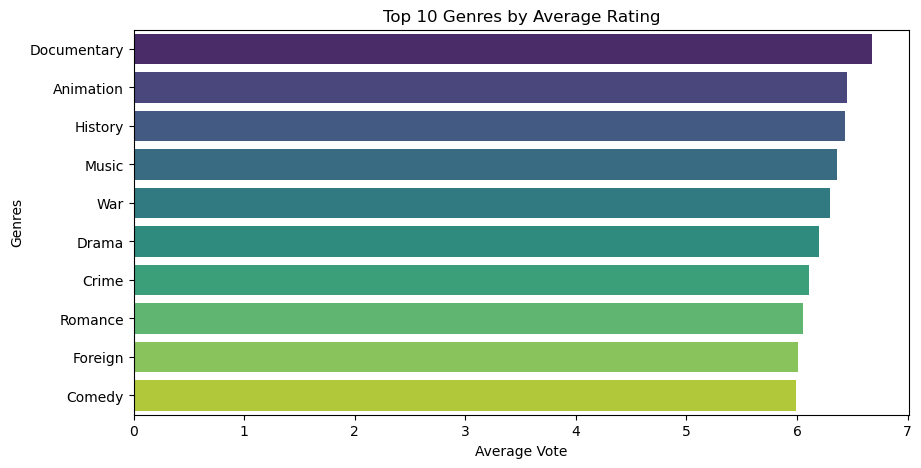

In [152]:
def top_genres_by_rating(df, top_n=10):
    import seaborn as sns

    genre_ratings = {}

    # Ensure empty or NaN values are removed
    filtered_df = merged_df.dropna(subset=["genres_str", "vote_average"])
    filtered_df = filtered_df[filtered_df["genres_str"].str.strip() != ""]

    for _, row in filtered_df.iterrows():
        genres = row['genres_str'].split(', ')  # Ensure proper format
        vote_avg = row['vote_average']

        for genre in genres:
            if genre not in genre_ratings:
                genre_ratings[genre] = []
            genre_ratings[genre].append(vote_avg)

    # Compute average rating for each genre (filtering genres with at least 5 occurrences)
    avg_ratings = {genre: sum(ratings) / len(ratings) for genre, ratings in genre_ratings.items() if len(ratings) > 5}
    sorted_genres = sorted(avg_ratings.items(), key=lambda x: x[1], reverse=True)[:top_n]

    genres, ratings = zip(*sorted_genres)

    # Plot results
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(ratings), y=list(genres), palette='viridis')
    plt.xlabel('Average Vote')
    plt.ylabel('Genres')
    plt.title(f'Top {top_n} Genres by Average Rating')
    plt.show()

# Visualize top genres by rating
top_genres_by_rating(merged_df)


### 4.12 Keyword Influence on Ratings & Popularity

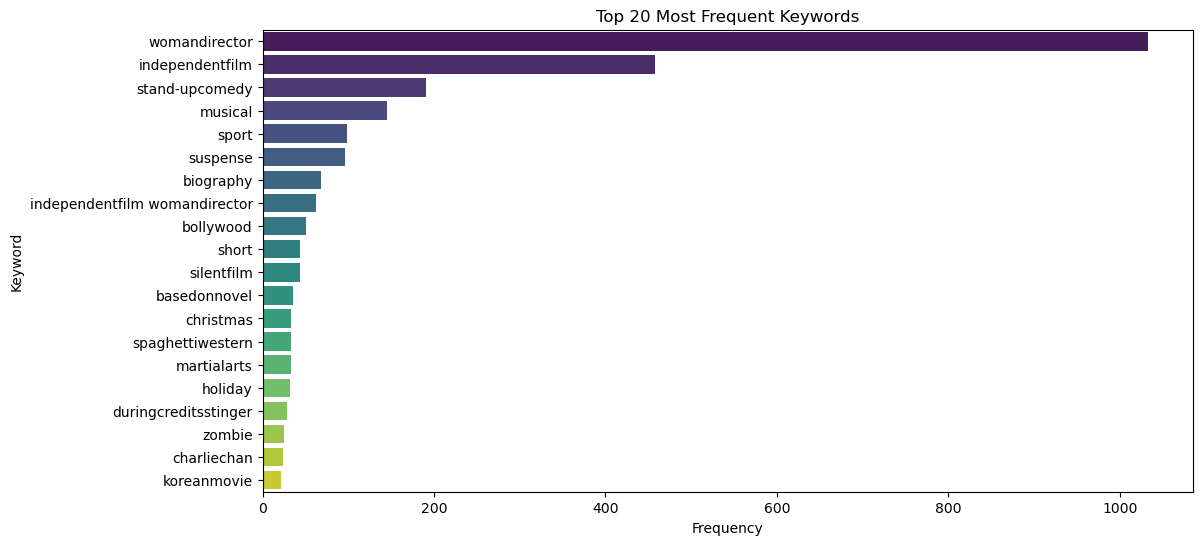

In [153]:
from collections import Counter

# Ensure 'keywords' column exists
merged_df['keywords_str'] = merged_df['keywords_str'].fillna('')

# Extract and count keywords
all_keywords = []
for keywords in merged_df['keywords_str']:
    all_keywords.extend(keywords.split(', '))

keyword_counts = Counter(all_keywords)

# Convert to DataFrame
keyword_freq_df = pd.DataFrame(keyword_counts.items(), columns=['keywords_str', 'Frequency'])

# Remove empty keyword rows (if any)
keyword_freq_df = keyword_freq_df[keyword_freq_df["keywords_str"] != ""]

keyword_freq_df = keyword_freq_df.sort_values(by='Frequency', ascending=False)

# Plot top 20 keywords
plt.figure(figsize=(12, 6))
sns.barplot(x=keyword_freq_df['Frequency'][:20], y=keyword_freq_df['keywords_str'][:20], palette='viridis')
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.title("Top 20 Most Frequent Keywords")
plt.show()


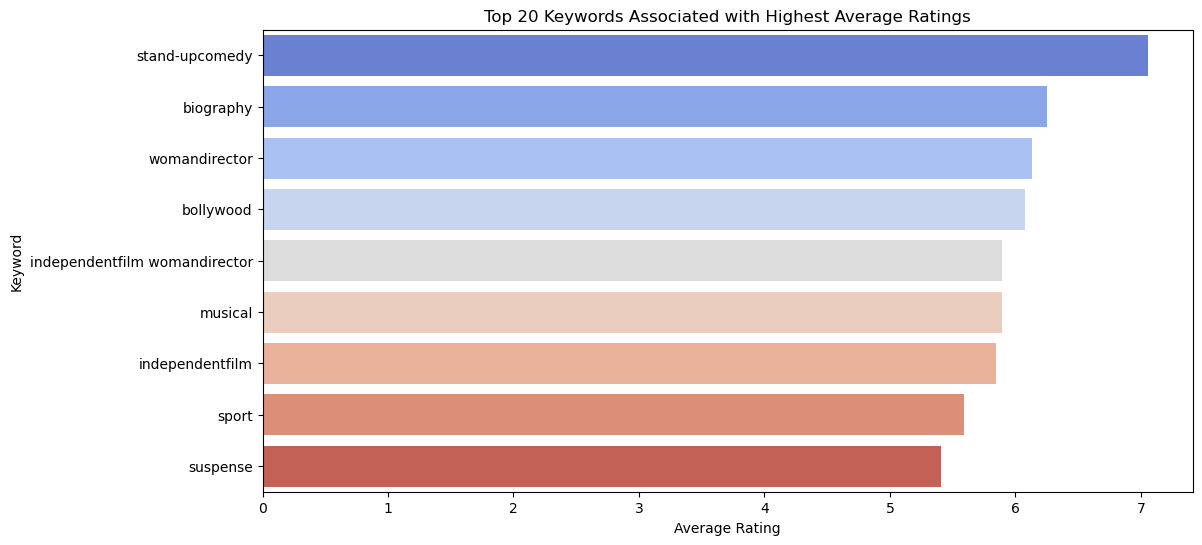

In [154]:
import seaborn as sns

# Drop rows where 'keywords_str' or 'vote_average' are empty or NaN
filtered_df = merged_df.dropna(subset=["keywords_str", "vote_average"])
filtered_df = filtered_df[filtered_df["keywords_str"].str.strip() != ""]

# Extract keywords and their corresponding ratings
keyword_ratings = []
for _, row in filtered_df.iterrows():
    keywords = row["keywords_str"].split(", ")  # Assuming keywords are comma-separated
    rating = row["vote_average"]
    for keyword in keywords:
        keyword_ratings.append((keyword, rating))

# Convert to DataFrame
keyword_ratings_df = pd.DataFrame(keyword_ratings, columns=["keywords_str", "Rating"])

# Compute average rating for each keyword (filtering keywords appearing at least 50 times)
keyword_avg_rating = keyword_ratings_df.groupby("keywords_str").filter(lambda x: len(x) >= 50).groupby("keywords_str")["Rating"].mean()

# Select the top 20 keywords with the highest ratings
top_keywords = keyword_avg_rating.nlargest(20)

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="coolwarm")
plt.xlabel("Average Rating")
plt.ylabel("Keyword")
plt.title("Top 20 Keywords Associated with Highest Average Ratings")
plt.show()

